<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/11_student_teacher_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student-Teacher Network for MNIST Classification

## Learning Objectives

By the end of this notebook, you will be able to:

* Train a teacher network to classify the MNIST dataset
* Understand knowledge distillation and how the student network learns from the teacher
* Implement and compare different student architectures
* Analyze the performance trade-offs between model size and accuracy

## 1. Introduction to Knowledge Distillation

Knowledge distillation is a technique where a smaller "student" model learns to mimic a larger "teacher" model. The student learns not just from the hard labels (correct classes) but also from the soft probabilities output by the teacher.

### Why Knowledge Distillation?
- **Model Compression**: Deploy smaller models on edge devices
- **Faster Inference**: Reduced computation time
- **Knowledge Transfer**: Student learns richer representations from teacher's outputs

## 2. Setup and Imports

In [3]:
# Install required packages

!pip install numpy pandas matplotlib seaborn torch tqdm scikit-learn torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Hyperparameters

In [14]:
# Training hyperparameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Knowledge distillation hyperparameters
temperature = 3.0  # Temperature for softening probability distributions
alpha = 0.7       # Weight for distillation loss vs hard target loss

## 4. Dataset Preparation

MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9). Each image is 28x28 pixels.

In [15]:
# Download and prepare MNIST dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False,
                           transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


## 5. Visualize Sample Data

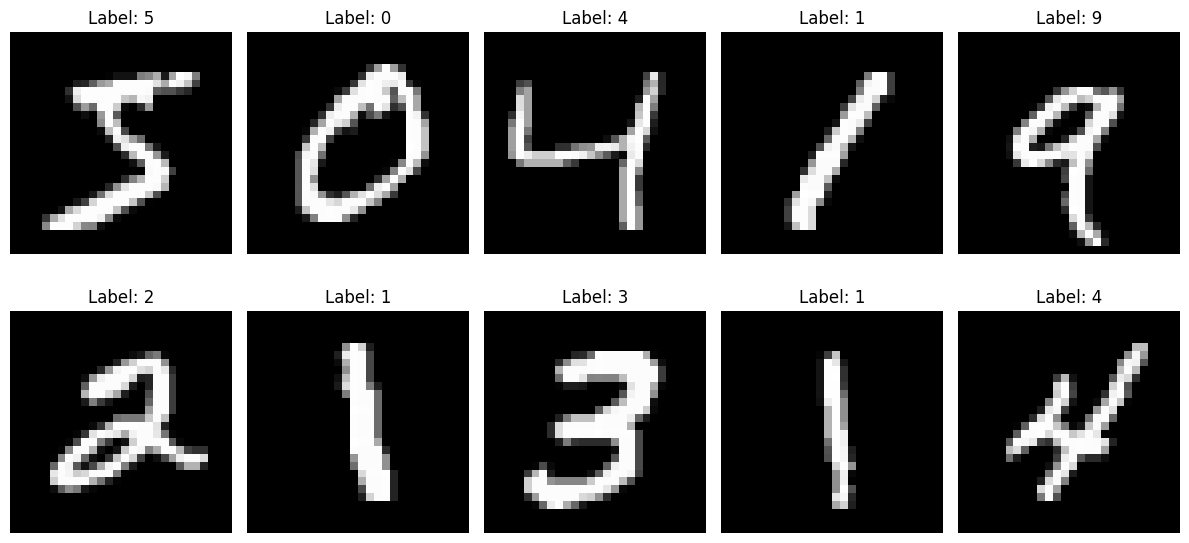

In [16]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 6. Model Architectures

### Teacher Network
A larger, more complex network with multiple convolutional layers.

In [17]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 300)
        self.fc2 = nn.Linear(300, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Calculate teacher model parameters
teacher_model = Teacher()
teacher_params = sum(p.numel() for p in teacher_model.parameters())
print(f"Teacher Network Parameters: {teacher_params:,}")

Teacher Network Parameters: 481,214


### Student Network
A smaller, simpler network that will learn from the teacher.

In [18]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(14*14*16, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

# Calculate student model parameters
student_model = Student()
student_params = sum(p.numel() for p in student_model.parameters())
print(f"Student Network Parameters: {student_params:,}")
print(f"Compression Ratio: {teacher_params/student_params:.2f}x")

Student Network Parameters: 31,562
Compression Ratio: 15.25x


## 7. Training Functions

In [19]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, model_name="Model"):
    """Standard training function for any model"""
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies

def test_model(model, test_loader, model_name="Model"):
    """Test function for any model"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100. * correct / total
    print(f'{model_name} - Test Accuracy: {accuracy:.2f}%')
    return accuracy

## 8. Train Teacher Network

In [26]:
# Initialize teacher
teacher = Teacher().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(teacher.parameters(), lr=learning_rate)

# Train teacher
print("Training Teacher Network...")
teacher_losses, teacher_accs = train_model(teacher, train_loader, criterion, optimizer, num_epochs, "Teacher")

# Test teacher
teacher_accuracy = test_model(teacher, test_loader, "Teacher")

Training Teacher Network...


Epoch 1/5: 100%|██████████| 600/600 [00:54<00:00, 11.08it/s, loss=0.0275, acc=95]   


Teacher - Epoch [1/5], Loss: 0.1625, Accuracy: 94.97%


Epoch 2/5: 100%|██████████| 600/600 [00:54<00:00, 11.03it/s, loss=0.0295, acc=98.1]


Teacher - Epoch [2/5], Loss: 0.0630, Accuracy: 98.06%


Epoch 3/5: 100%|██████████| 600/600 [00:54<00:00, 11.07it/s, loss=0.0576, acc=98.6] 


Teacher - Epoch [3/5], Loss: 0.0479, Accuracy: 98.56%


Epoch 4/5: 100%|██████████| 600/600 [00:54<00:00, 10.98it/s, loss=0.00391, acc=98.7]


Teacher - Epoch [4/5], Loss: 0.0407, Accuracy: 98.73%


Epoch 5/5: 100%|██████████| 600/600 [00:54<00:00, 10.99it/s, loss=0.00936, acc=98.9] 


Teacher - Epoch [5/5], Loss: 0.0351, Accuracy: 98.91%
Teacher - Test Accuracy: 99.25%


## 9. Knowledge Distillation Training

Now we'll train the student using knowledge distillation. The student learns from:
1. **Hard targets**: The true labels (standard cross-entropy loss)
2. **Soft targets**: The teacher's output probabilities (KL divergence loss)

In [21]:
def train_student_distillation(student, teacher, train_loader, num_epochs, temperature=3.0, alpha=0.7):
    """Train student using knowledge distillation"""
    student.train()
    teacher.eval()  # Teacher in evaluation mode

    # Freeze teacher parameters
    for param in teacher.parameters():
        param.requires_grad = False

    criterion_hard = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Get teacher outputs
            with torch.no_grad():
                teacher_outputs = teacher(images)

            # Get student outputs
            student_outputs = student(images)

            # Calculate losses
            loss_hard = criterion_hard(student_outputs, labels)

            # 2. Soft target loss (KL divergence)
            T = temperature
            loss_soft = nn.KLDivLoss(reduction='batchmean')(
                F.log_softmax(student_outputs / T, dim=1),
                F.softmax(teacher_outputs / T, dim=1)
            ) * (T * T)

            # Combined loss
            loss = alpha * loss_hard + (1 - alpha) * loss_soft

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Student (Distilled) - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies

In [22]:
# Initialize student for distillation
student_distilled = Student().to(device)

# Train student with knowledge distillation
print("\nTraining Student Network with Knowledge Distillation...")
distilled_losses, distilled_accs = train_student_distillation(
    student_distilled, teacher, train_loader, num_epochs, temperature, alpha
)

# Test distilled student
distilled_accuracy = test_model(student_distilled, test_loader, "Student (Distilled)")


Training Student Network with Knowledge Distillation...


Epoch 1/5: 100%|██████████| 600/600 [00:27<00:00, 21.87it/s, loss=0.173, acc=94.3] 


Student (Distilled) - Epoch [1/5], Loss: 0.3670, Accuracy: 94.25%


Epoch 2/5: 100%|██████████| 600/600 [00:26<00:00, 22.35it/s, loss=0.112, acc=97.6] 


Student (Distilled) - Epoch [2/5], Loss: 0.1319, Accuracy: 97.58%


Epoch 3/5: 100%|██████████| 600/600 [00:26<00:00, 22.36it/s, loss=0.133, acc=97.9] 


Student (Distilled) - Epoch [3/5], Loss: 0.1179, Accuracy: 97.86%


Epoch 4/5: 100%|██████████| 600/600 [00:26<00:00, 22.62it/s, loss=0.0961, acc=98]  


Student (Distilled) - Epoch [4/5], Loss: 0.1079, Accuracy: 98.01%


Epoch 5/5: 100%|██████████| 600/600 [00:27<00:00, 22.13it/s, loss=0.0765, acc=98.2]


Student (Distilled) - Epoch [5/5], Loss: 0.1013, Accuracy: 98.16%
Student (Distilled) - Test Accuracy: 97.92%


## 10. Train Student Without Distillation (Baseline)

In [24]:
# Initialize student for baseline training
student_baseline = Student().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_baseline.parameters(), lr=learning_rate)

# Train student without distillation
print("\nTraining Student Network WITHOUT Knowledge Distillation (Baseline)...")
baseline_losses, baseline_accs = train_model(
    student_baseline, train_loader, criterion, optimizer, num_epochs, "Student (Baseline)"
)

# Test baseline student
baseline_accuracy = test_model(student_baseline, test_loader, "Student (Baseline)")


Training Student Network WITHOUT Knowledge Distillation (Baseline)...


Epoch 1/5: 100%|██████████| 600/600 [00:15<00:00, 39.86it/s, loss=0.0656, acc=94.1]


Student (Baseline) - Epoch [1/5], Loss: 0.2001, Accuracy: 94.14%


Epoch 2/5: 100%|██████████| 600/600 [00:14<00:00, 40.29it/s, loss=0.0944, acc=97.7]


Student (Baseline) - Epoch [2/5], Loss: 0.0781, Accuracy: 97.70%


Epoch 3/5: 100%|██████████| 600/600 [00:15<00:00, 39.67it/s, loss=0.029, acc=98.2]  


Student (Baseline) - Epoch [3/5], Loss: 0.0595, Accuracy: 98.20%


Epoch 4/5: 100%|██████████| 600/600 [00:15<00:00, 39.77it/s, loss=0.0264, acc=98.5] 


Student (Baseline) - Epoch [4/5], Loss: 0.0475, Accuracy: 98.52%


Epoch 5/5: 100%|██████████| 600/600 [00:14<00:00, 40.04it/s, loss=0.0167, acc=98.8] 


Student (Baseline) - Epoch [5/5], Loss: 0.0397, Accuracy: 98.76%
Student (Baseline) - Test Accuracy: 98.16%


## 11. Results Comparison

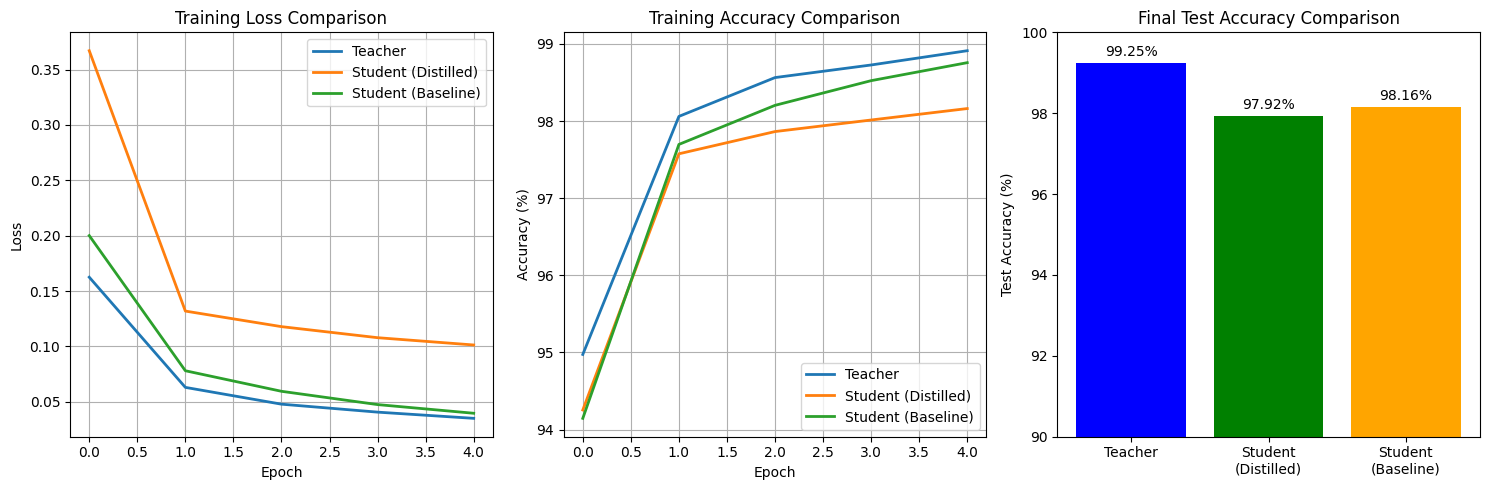


=== Summary ===
Teacher Parameters: 481,214
Student Parameters: 31,562
Compression Ratio: 15.25x

Test Accuracies:
  Teacher: 99.25%
  Student (Distilled): 97.92%
  Student (Baseline): 98.16%

Improvement from Distillation: -0.24%


In [27]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(teacher_losses, label='Teacher', linewidth=2)
plt.plot(distilled_losses, label='Student (Distilled)', linewidth=2)
plt.plot(baseline_losses, label='Student (Baseline)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(teacher_accs, label='Teacher', linewidth=2)
plt.plot(distilled_accs, label='Student (Distilled)', linewidth=2)
plt.plot(baseline_accs, label='Student (Baseline)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)

# Bar plot of final test accuracies
plt.subplot(1, 3, 3)
models = ['Teacher', 'Student\n(Distilled)', 'Student\n(Baseline)']
accuracies = [teacher_accuracy, distilled_accuracy, baseline_accuracy]
colors = ['blue', 'green', 'orange']
bars = plt.bar(models, accuracies, color=colors)
plt.ylabel('Test Accuracy (%)')
plt.title('Final Test Accuracy Comparison')
plt.ylim(90, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Summary ===")
print(f"Teacher Parameters: {teacher_params:,}")
print(f"Student Parameters: {student_params:,}")
print(f"Compression Ratio: {teacher_params/student_params:.2f}x")
print(f"\nTest Accuracies:")
print(f"  Teacher: {teacher_accuracy:.2f}%")
print(f"  Student (Distilled): {distilled_accuracy:.2f}%")
print(f"  Student (Baseline): {baseline_accuracy:.2f}%")
print(f"\nImprovement from Distillation: {distilled_accuracy - baseline_accuracy:.2f}%")

## 12. Visualize Model Predictions

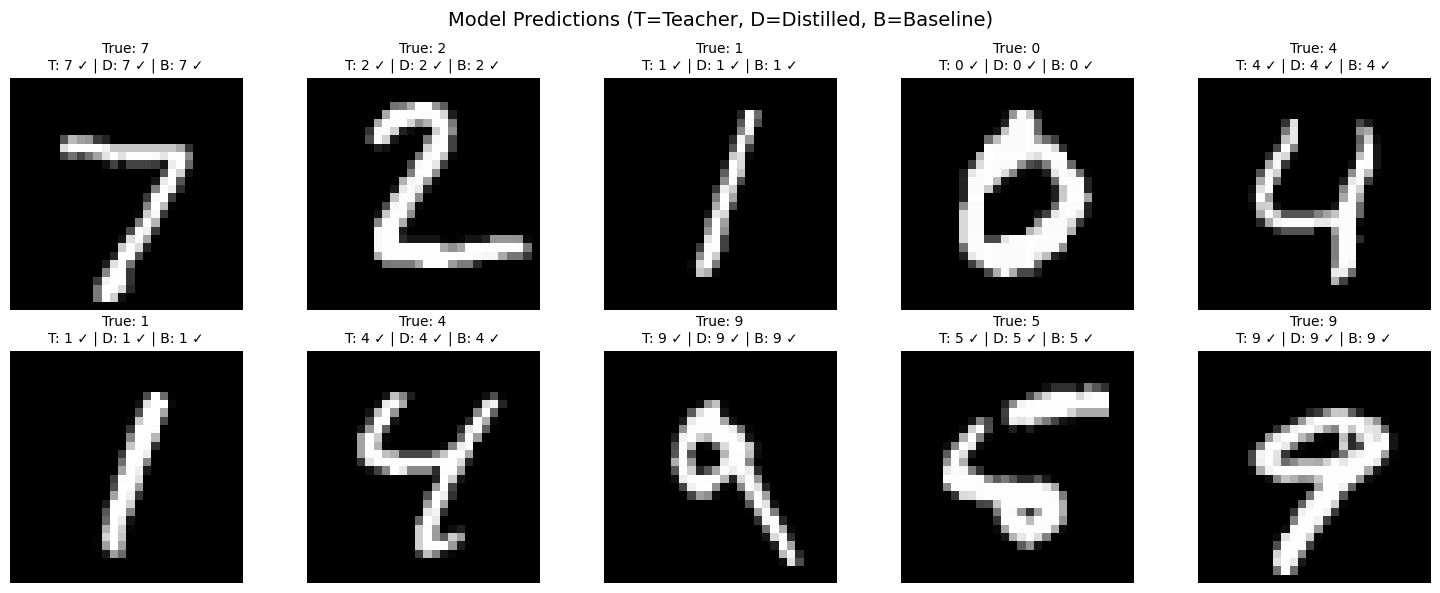

In [28]:
def visualize_predictions(teacher, student_distilled, student_baseline, test_loader, num_samples=10):
    """Visualize predictions from all three models"""
    teacher.eval()
    student_distilled.eval()
    student_baseline.eval()

    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]

    # Get predictions
    with torch.no_grad():
        teacher_outputs = teacher(images)
        distilled_outputs = student_distilled(images)
        baseline_outputs = student_baseline(images)

    _, teacher_preds = torch.max(teacher_outputs, 1)
    _, distilled_preds = torch.max(distilled_outputs, 1)
    _, baseline_preds = torch.max(baseline_outputs, 1)

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            img = images[i].cpu().squeeze()
            ax.imshow(img, cmap='gray')

            # Create title with predictions
            true_label = labels[i].item()
            t_pred = teacher_preds[i].item()
            d_pred = distilled_preds[i].item()
            b_pred = baseline_preds[i].item()

            title = f'True: {true_label}\n'
            title += f'T: {t_pred} '
            title += '✓' if t_pred == true_label else '✗'
            title += f' | D: {d_pred} '
            title += '✓' if d_pred == true_label else '✗'
            title += f' | B: {b_pred} '
            title += '✓' if b_pred == true_label else '✗'

            ax.set_title(title, fontsize=10)
            ax.axis('off')

    plt.suptitle('Model Predictions (T=Teacher, D=Distilled, B=Baseline)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(teacher, student_distilled, student_baseline, test_loader)

---

# Challenge Section


## Challenge 1: Implement a Different Student Architecture

Design a new student architecture that:
- Has even fewer parameters than the current student
- Uses a different approach (e.g., only fully connected layers, or different conv architecture)
- Achieves at least 95% accuracy with distillation

**Hint**: You might want to experiment with:
- Different kernel sizes
- Depthwise separable convolutions
- Different activation functions

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyStudent(nn.Module):
    def __init__(self):
        super(TinyStudent, self).__init__()
        # we split convlutions into dept and point wise
        
        # 1 → 8 (depthwise + pointwise)
        self.depthwise1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, groups=1, bias=False)
        self.pointwise1 = nn.Conv2d(1, 8, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        # 8 → 16 (depthwise + pointwise)
        self.depthwise2 = nn.Conv2d(8, 8, kernel_size=3, padding=1, groups=8, bias=False)
        self.pointwise2 = nn.Conv2d(8, 16, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2)

        # Fully connected layer
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        # First block
        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = self.bn1(x)
        x = F.silu(x)
        x = self.pool(x)  # [B, 8, 14, 14]

        # Second block
        x = self.depthwise2(x)
        x = self.pointwise2(x)
        x = self.bn2(x)
        x = F.silu(x)
        x = self.pool(x)  # [B, 16, 7, 7]

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
tiny_model = TinyStudent()
tiny_params = sum(p.numel() for p in tiny_model.parameters())
print(f"TinyStudent Parameters: {tiny_params:,}")
# Initialize student for distillation
student_distilled = TinyStudent().to(device)

# Train student with knowledge distillation
print("\nTraining the TinyStudent Network with Knowledge Distillation...")
distilled_losses, distilled_accs = train_student_distillation(
    student_distilled, teacher, train_loader, num_epochs, temperature, alpha
)

# Test distilled student
distilled_accuracy = test_model(student_distilled, test_loader, "Student (Distilled)")


TinyStudent Parameters: 8,115

Training the TinyStudent Network with Knowledge Distillation...


Epoch 1/5: 100%|██████████| 600/600 [00:42<00:00, 14.15it/s, loss=0.33, acc=90.4] 


Student (Distilled) - Epoch [1/5], Loss: 1.0900, Accuracy: 90.42%


Epoch 2/5: 100%|██████████| 600/600 [00:41<00:00, 14.37it/s, loss=0.413, acc=96.1]


Student (Distilled) - Epoch [2/5], Loss: 0.3770, Accuracy: 96.13%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.35it/s, loss=0.152, acc=97.1]


Student (Distilled) - Epoch [3/5], Loss: 0.2752, Accuracy: 97.11%


Epoch 4/5: 100%|██████████| 600/600 [00:42<00:00, 14.25it/s, loss=0.321, acc=97.6] 


Student (Distilled) - Epoch [4/5], Loss: 0.2263, Accuracy: 97.61%


Epoch 5/5: 100%|██████████| 600/600 [00:42<00:00, 14.25it/s, loss=0.248, acc=97.8] 


Student (Distilled) - Epoch [5/5], Loss: 0.1966, Accuracy: 97.81%
Student (Distilled) - Test Accuracy: 97.83%


## Challenge 2: Temperature Analysis

Investigate how different temperature values affect the student's learning:
1. Train students with temperatures T = [1, 3, 5, 10, 20]
2. Plot the relationship between temperature and final accuracy
3. Explain your findings


Training with temperature = 1


Epoch 1/5: 100%|██████████| 600/600 [00:41<00:00, 14.34it/s, loss=0.0716, acc=92.2]


Student (Distilled) - Epoch [1/5], Loss: 0.2688, Accuracy: 92.17%


Epoch 2/5: 100%|██████████| 600/600 [00:41<00:00, 14.37it/s, loss=0.0292, acc=96.6]


Student (Distilled) - Epoch [2/5], Loss: 0.1067, Accuracy: 96.56%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.35it/s, loss=0.0335, acc=97.2]


Student (Distilled) - Epoch [3/5], Loss: 0.0825, Accuracy: 97.24%


Epoch 4/5: 100%|██████████| 600/600 [00:41<00:00, 14.30it/s, loss=0.0671, acc=97.6]


Student (Distilled) - Epoch [4/5], Loss: 0.0707, Accuracy: 97.62%


Epoch 5/5: 100%|██████████| 600/600 [00:41<00:00, 14.35it/s, loss=0.0705, acc=97.9] 


Student (Distilled) - Epoch [5/5], Loss: 0.0624, Accuracy: 97.89%
Model - Test Accuracy: 97.75%

Training with temperature = 3


Epoch 1/5: 100%|██████████| 600/600 [00:41<00:00, 14.29it/s, loss=0.462, acc=91.5]


Student (Distilled) - Epoch [1/5], Loss: 1.4419, Accuracy: 91.52%


Epoch 2/5: 100%|██████████| 600/600 [00:41<00:00, 14.34it/s, loss=0.38, acc=96.7] 


Student (Distilled) - Epoch [2/5], Loss: 0.4057, Accuracy: 96.73%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.34it/s, loss=0.255, acc=97.4]


Student (Distilled) - Epoch [3/5], Loss: 0.3036, Accuracy: 97.45%


Epoch 4/5: 100%|██████████| 600/600 [00:41<00:00, 14.42it/s, loss=0.197, acc=97.8]


Student (Distilled) - Epoch [4/5], Loss: 0.2537, Accuracy: 97.82%


Epoch 5/5: 100%|██████████| 600/600 [00:41<00:00, 14.38it/s, loss=0.15, acc=98.1]  


Student (Distilled) - Epoch [5/5], Loss: 0.2260, Accuracy: 98.06%
Model - Test Accuracy: 98.02%

Training with temperature = 5


Epoch 1/5: 100%|██████████| 600/600 [00:41<00:00, 14.42it/s, loss=1.03, acc=91.3] 


Student (Distilled) - Epoch [1/5], Loss: 2.8350, Accuracy: 91.32%


Epoch 2/5: 100%|██████████| 600/600 [00:41<00:00, 14.41it/s, loss=0.851, acc=96.4]


Student (Distilled) - Epoch [2/5], Loss: 0.8874, Accuracy: 96.36%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.39it/s, loss=0.499, acc=97.3]


Student (Distilled) - Epoch [3/5], Loss: 0.6589, Accuracy: 97.28%


Epoch 4/5: 100%|██████████| 600/600 [00:41<00:00, 14.42it/s, loss=0.522, acc=97.6]


Student (Distilled) - Epoch [4/5], Loss: 0.5570, Accuracy: 97.60%


Epoch 5/5: 100%|██████████| 600/600 [00:41<00:00, 14.35it/s, loss=0.499, acc=97.9]


Student (Distilled) - Epoch [5/5], Loss: 0.5001, Accuracy: 97.86%
Model - Test Accuracy: 98.02%

Training with temperature = 10


Epoch 1/5: 100%|██████████| 600/600 [00:41<00:00, 14.41it/s, loss=2.1, acc=88.8] 


Student (Distilled) - Epoch [1/5], Loss: 4.5901, Accuracy: 88.76%


Epoch 2/5: 100%|██████████| 600/600 [00:42<00:00, 14.26it/s, loss=1.44, acc=95.9]


Student (Distilled) - Epoch [2/5], Loss: 1.5914, Accuracy: 95.89%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.29it/s, loss=1.1, acc=96.7]  


Student (Distilled) - Epoch [3/5], Loss: 1.2469, Accuracy: 96.66%


Epoch 4/5: 100%|██████████| 600/600 [00:41<00:00, 14.38it/s, loss=0.937, acc=97.1]


Student (Distilled) - Epoch [4/5], Loss: 1.0709, Accuracy: 97.07%


Epoch 5/5: 100%|██████████| 600/600 [00:41<00:00, 14.30it/s, loss=0.987, acc=97.3]


Student (Distilled) - Epoch [5/5], Loss: 0.9700, Accuracy: 97.34%
Model - Test Accuracy: 97.77%

Training with temperature = 20


Epoch 1/5: 100%|██████████| 600/600 [00:41<00:00, 14.37it/s, loss=1.86, acc=89.6]


Student (Distilled) - Epoch [1/5], Loss: 4.1861, Accuracy: 89.61%


Epoch 2/5: 100%|██████████| 600/600 [00:41<00:00, 14.30it/s, loss=1.41, acc=96]  


Student (Distilled) - Epoch [2/5], Loss: 1.5465, Accuracy: 96.00%


Epoch 3/5: 100%|██████████| 600/600 [00:41<00:00, 14.43it/s, loss=1.32, acc=96.7] 


Student (Distilled) - Epoch [3/5], Loss: 1.2549, Accuracy: 96.67%


Epoch 4/5: 100%|██████████| 600/600 [00:41<00:00, 14.39it/s, loss=0.986, acc=97.1]


Student (Distilled) - Epoch [4/5], Loss: 1.0993, Accuracy: 97.10%


Epoch 5/5: 100%|██████████| 600/600 [02:12<00:00,  4.52it/s, loss=0.989, acc=97.3]


Student (Distilled) - Epoch [5/5], Loss: 1.0102, Accuracy: 97.31%
Model - Test Accuracy: 97.47%


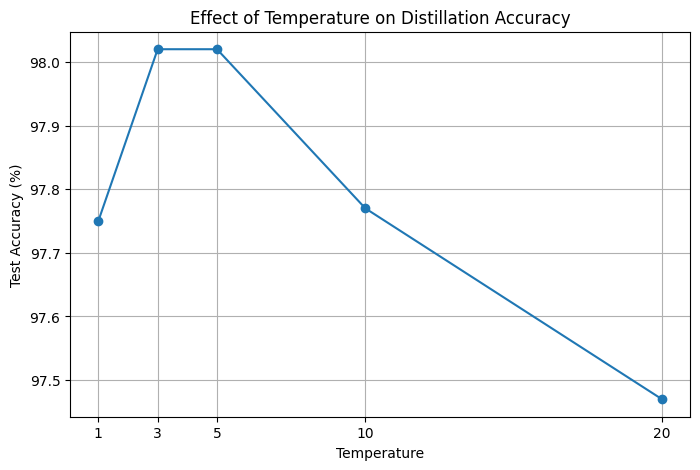

In [33]:
temperatures = [1, 3, 5, 10, 20]
temperature_results = []

# TODO: For each temperature:
# 1. Create a new student model
# 2. Train it with that temperature
# 3. Test it and store the accuracy
for temp in temperatures:
    print(f"\nTraining with temperature = {temp}")
    
    # 1. Create a new TinyStudent model
    student = TinyStudent().to(device)
    
    # 2. Train with distillation at current temperature
    _, _ = train_student_distillation(
        student, teacher, train_loader,
        num_epochs= num_epochs,
        temperature=temp,
        alpha=0.5  
    )
    
    # 3. Test the model and save the accuracy
    acc = test_model(student, test_loader)
    temperature_results.append(acc)

# Create a plot showing temperature vs accuracy

# What we can see is that as the temparature increases the output softwmax smoothens out and if goes beyoond a level then learning rate decreases

plt.figure(figsize=(8, 5))
plt.plot(temperatures, temperature_results, marker='o', linestyle='-')
plt.title("Effect of Temperature on Distillation Accuracy")
plt.xlabel("Temperature")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.xticks(temperatures)
plt.show()

## Challenge 3: Multi-Teacher Distillation

Implement a system where a student learns from multiple teachers:
1. Train 3 different teacher architectures
2. Combine their knowledge to train a single student
3. Compare with single-teacher distillation

**Hint**: You can average the soft targets from multiple teachers or use a weighted combination.

In [17]:
# TODO: Define 3 different teacher architectures
class Teacher1(nn.Module):
    # Different architecture
    pass

class Teacher2(nn.Module):
    # Different architecture
    pass

class Teacher3(nn.Module):
    # Different architecture
    pass

# TODO: Implement multi-teacher distillation training function
def train_student_multi_teacher(student, teachers, train_loader, num_epochs):
    # Your implementation here
    pass

## Challenge 4: Distillation for Other Datasets

Apply knowledge distillation to a more complex dataset:
1. Use CIFAR-10 dataset (color images, 10 classes)
2. Design appropriate teacher and student architectures
3. Compare the effectiveness of distillation on CIFAR-10 vs MNIST

**Questions to answer**:
- Is the improvement from distillation more or less pronounced on CIFAR-10?
- What architectural choices work best for color images?

In [18]:
# TODO: Load CIFAR-10 dataset
# TODO: Design teacher and student architectures for CIFAR-10
# TODO: Train and compare results

## Challenge 5: Analysis Questions

Answer the following questions based on your experiments:

1. **Why does knowledge distillation work?** Explain in your own words why learning from soft targets helps the student network.

2. **When might distillation fail?** Can you think of scenarios where knowledge distillation might not help or even hurt performance?

3. **Real-world applications**: List 3 real-world scenarios where knowledge distillation would be particularly useful.

4. **Optimal α value**: Based on your experiments, what seems to be the optimal balance between hard and soft targets? Does this depend on the dataset or architecture?

In [19]:
# Your answers here:
# 1. Why does knowledge distillation work?
# Answer: Knowledge distillation works because soft targets from the teacher network provide better and required information than hard labels, teacher's outputs show how confident it is across all classes.

# 2. When might distillation fail?
# Answer:  1.If the teacher is inaccurate, the student may learn incorrect patterns. 2.Choosing the wrong balance between soft and hard loss can lead to poor training. 3. : If teacher and student are trained/tested on very different data types, knowledge may not transfer well.

# 3. Real-world applications:
# Answer: 1.In cloud services where inference cost matters (e.g., recommendation systems), distillation helps reduce compute 2.Compress large models (like BERT) into tiny versions to run on phones, IoT devices, etc.

# 4. Optimal α value:
# Answer: Based on experiments, an α value around 0.7, but value depends on student's capacity and quality of the teacher

## Bonus Challenge: Implement Progressive Distillation

Implement a progressive distillation approach where:
1. Train a large teacher
2. Train a medium-sized student from the teacher
3. Train a tiny student from the medium student
4. Compare this "chain" approach with direct distillation from teacher to tiny student

In [20]:
# TODO: Implement progressive distillation
# Your code here